In [120]:
%matplotlib inline

# For interactivity
# %matplotlib widget

# All imports
from random import choice
import numpy as np
import matplotlib.pyplot as plt

# Set number of decimal places to show
np.set_printoptions(formatter={'float': '{:.4f}'.format})

In [121]:
"""
Live updating:
use display.clear_output(wait=True)
Make an array for figures
Save figure by doing plt.plot, then append, then plt.close
Then to live update, display each figure using clear_output and then display.display()
use plt.clf() to clear figure
Maybe can stream instead of saving all figs?
"""

"""
Helpful functions: np.concatenate
Can choose axis to concat along
"""

'\nHelpful functions: np.concatenate\nCan choose axis to concat along\n'

In [122]:
def sigmoid(x: float) -> float:
    """Returns the sigmoid

    Args:
        x (float): the input

    Returns:
        float: the sigmoid of the input
    """
    return 1./(1. + np.exp(-x))

def sigmoid_prime(x: float) -> float:
    """Return the derivative of the sigmoid function

    Args:
        x (float): the input

    Returns:
        float: the derivative of the sigmoid of the input
    """
    return x*(1.-x)

def tanh(x: float) -> float:
    """Returns the hyperbolic tangent

    Args:
        x (float): input

    Returns:
        float: hyperbolic tangent of x
    """
    return ((np.exp(x) - np.exp(-x))/(np.exp(x) + np.exp(-x)))

def tanh_prime(x: float) -> float:
    """Returns the derivative of the hyperbolic tangent

    Args:
        x (float): input

    Returns:
        float: derivative of the hyperbolic tangent of x
    """
    g = tanh(x)
    return (1. - g**2)

In [ ]:
class NeuralNetwork:
    def __init__(self, layers: list, activation: str='sigmoid', verbose=False):
        """Cosntructor for neural network

        Args:
            layers (list): number of inputs, hidden layers, and outputs as a list
            activation (str, optional): activation function to use. Only sigmoid and tanh are available. Defaults to 'signmoid'.
        """
        self.num_layers = len(layers)
        self.num_inputs = layers[0]
        self.num_outputs = layers[-1]
        self.num_hidden_layers = len(layers) - 1
        self.layers = layers
        if verbose:
            print(f"num_inputs = {self.num_inputs}\nnum_outputs = {self.num_outputs}\nlayers = {self.layers}")
        
        # Create random weights
        self.weights = []
        for i in range(self.num_layers - 1):
            # Add bias weight for each neuron if not last layer
            if i == self.num_layers - 1:
                curr_weights = np.random.rand(layers[i], layers[i+1])
            else:
                curr_weights = np.random.rand(layers[i] + 1, layers[i+1])
            self.weights.append(curr_weights)

        if verbose:
            for layer, weights in enumerate(self.weights):
                print(f"weights[{layer}]:\n{weights}")
                print(f"weights[{layer}].shape: {weights.shape}")
                print()
        
        if activation == "sigmoid":
            self.activation = sigmoid
            self.activation_derivative = sigmoid_prime
        elif activation == "tanh":
            self.activation = tanh
            self.activation_derivative = tanh_prime
        else:
            raise Exception("Activation function must be 'sigmoid' or 'tanh'")

        # Array to store post-activations for each layer; for n layers, there are n - 1 activations, as layer n - 1, the output layer,
        # does not have an activation
        self.activations = [np.array([]) for _ in range(self.num_layers - 1)]
        # Array to store inputs for each layer. Last layer's 'input' is the activation of the last hidden layer
        self.inputs = [np.array([]) for _ in range(self.num_layers)]
        self.errors = []
        self.errors_squared = []
        self.is_trained = False

    def forward_prop(self, X: np.ndarray, verbose: bool=False):
        """runs forward propagation through the NN for a given input.

        Args:
            X (np.ndarray): the training sample
            verbose (bool, optional): Flag to print out statement. Defaults to False.

        Returns:
            _type_: _description_
        """
        # Add to inputs array
        X = np.atleast_2d(X) # Convert to 2D matrix
        # Add bias to first input
        X = np.concatenate((X, np.ones((1, 1))), axis=1)
        self.inputs[0] = X
        if verbose:
            print("inputs:", self.inputs[0])
        
        for layer, weight in enumerate(self.weights):
            curr_layer_input = self.inputs[layer]
            
            if verbose:
                print(f"layer {layer}, curr_input.shape: {curr_layer_input.shape}")
                print(f"Layer {layer}, curr_input: {curr_layer_input}")
                print(self.inputs)
            
            dot_product = np.dot(curr_layer_input, weight)
            z_curr_layer = np.atleast_2d(self.activation(dot_product)) # Apply activation function
            
            # Save activation of curr layer
            self.activations[layer] = z_curr_layer
            # Save input to next layer after adding bias if next layer is not output layer
            if not layer == self.num_layers - 2:
                next_layer_input = np.concatenate((z_curr_layer, np.ones((1, 1))), axis=1)
                self.inputs[layer + 1] = next_layer_input
            else:
                self.inputs[layer + 1] = z_curr_layer
        
        if verbose:
            print("activations:")
            print(self.activations)
            print("inputs:")
            print(self.inputs)
        # self.activations has length n - 1. activations[0] is the output of layer 0, so activations[n-2] is the 
        # output of the last hidden layer, aka the output of the NN. Layer n - 1 is the output layer and has no 
        # activations
        return self.activations[-1]
    
    def __backprop(self, alpha: float = 0.02, verbose=False):
        """back propagation method that updates weights for an NN by sampling from 

        Args:
            alpha (float, optional): learning rate. Defaults to 0.02.
            verbose (bool, optional): whether to print out statements. Defaults to False.

        Returns:
            None
        """
        if not self.is_trained:
            raise Exception("backprop can only be called through the fit() method")
        # Keep track of deltas, weight updates, and errors at each pass
        deltas = [np.array([]) for _ in range(self.num_hidden_layers)]
        weight_updates = [np.array([]) for _ in range(self.num_hidden_layers)]
        sample = np.random.choice(len(self.X))
        curr_sample = self.X[sample]
        curr_target = self.target[sample]
        if isinstance(curr_sample, np.ndarray) and not len(curr_sample) == self.num_inputs:
                raise Exception("Number of inputs must match those specified in architecture")
        if isinstance(curr_target, np.ndarray) and not len(curr_target) == self.num_outputs:
                raise Exception("Number of outputs must match those specified in architecture and be supplied as a list")

        z = self.forward_prop(curr_sample, False)
        if verbose:
            print(z)
        curr_target = np.atleast_2d(curr_target)
        error = np.array(curr_target - z)
        self.errors.append(error.squeeze())
        self.errors_squared.append(error**2)

        # output layer delta has diff formula
        delta_last = (curr_target - z)*self.activation_derivative(z)
        deltas[-1] = delta_last
        # self.inputs' last element is the NN output, so one before that is the input for the last hidden layer
        delta_weights_output = np.dot(self.inputs[self.num_layers - 2].T, delta_last)*alpha
        weight_updates[-1] = delta_weights_output
        
        self.weights[-1] += delta_weights_output
        if verbose:
            print(f"Backprop for layer {self.num_hidden_layers - 1} done\n")
        # Start backprop-ing starting from layer (n-3), as layer (n-2) weights have been updated.
        for curr_layer in range(self.num_layers - 3, -1, -1):
            if verbose: 
                print(f"backprop from layer {curr_layer + 1} to {curr_layer} out of {self.num_layers} layers")
            
            # Drop the bias activation value from the next layer, so do not take input of next layer, 
            # just activation of current layer. This is z^(i)
            next_layer_activations = self.activations[curr_layer]
            next_layer_weights = self.weights[curr_layer + 1]
            # Drop the weights of the bias neuron from next layer
            next_layer_weights = next_layer_weights[:-1, :]
            
            delta_curr_layer = sigmoid_prime(next_layer_activations)*np.dot(deltas[curr_layer + 1], next_layer_weights.T)
            deltas[curr_layer] = delta_curr_layer
            curr_inputs = self.inputs[curr_layer]
            weight_update_curr_layer = alpha*np.dot(curr_inputs.T, delta_curr_layer)
            weight_updates[curr_layer] = weight_update_curr_layer
            self.weights[curr_layer] += weight_update_curr_layer
            if verbose: 
                print(f"Backprop for layer {curr_layer} done")
                # print(f"Weight updates:\n{weight_update_curr_layer}")
                print()
        
        return 0

    def fit(self, X:np.array, y:np.array, learning_rate:float=0.2, steps:float=10**5, tol:float = 10**-2, verbose:bool = False):
        """Method to train a neural network

        Args:
            X (np.array): Training data
            y (np.array): Target data
            learning_rate (float, optional): learning rate of the NN. Defaults to 0.2.
            steps (float, optional): no. steps to train for. Defaults to 10**5.
            tol (float, optional): error value below which training exits. Defaults to 10**-2.
            verbose (bool, optional): Flag to print out statements. Defaults to False.
        """
        if not isinstance(X, np.ndarray) or not X.any():
            raise Exception("Input must be given and be a numpy array")
        if not isinstance(y, np.ndarray) or not y.any():
            raise Exception("Target outputs must be supplied as a numpy array")
        if not len(X) == len(y):
            raise Exception(f"Training data length must match target data length {X.shape} != {y.shape}")
        self.X = X
        self.target = y
        self.is_trained = True
        old_weights = self.weights

        for iter in range(0, steps + 1):
            self.__backprop(learning_rate, verbose)

            if (iter) % (int(steps*0.1)) == 0:
                print(f"Step: {iter}")
                print("Training Results(data, prediction, expected):")
                self.predict_many(self.X, self.target)
                # RMS_error = self.__find_RMS_error_across_all_errors(int(max(0, iter - steps*0.1)))
                RMS_error = self.__find_RMS_error()
                print(f"RMS_err: {RMS_error}\n")
                if RMS_error <= tol:
                    print("NN training succeded!")
                    return
        if RMS_error > tol:
            print("NN training failed.")

        return

    def __find_RMS_error(self):
        """private method to find RMS error

        Args:
            X (_type_): _description_
            y (_type_): _description_
        """
        rms_errors = []
        for i, sample in enumerate(self.X):
            output = self.forward_prop(sample)
            error = self.target[i] - output
            rms_errors.append(error)
        return np.sqrt(np.mean(np.array(rms_errors)**2))
    
    def __find_RMS_error_across_all_errors(self, start_idx):
        """private method to find RMS error

        Args:
            X (_type_): _description_
            y (_type_): _description_
        """
        if not self.is_trained:
            raise Exception("RMS error can only be calculated through the fit() method")
        return np.sqrt(np.mean(np.array(self.errors[start_idx:])**2))

    def predict(self, x: np.ndarray) -> np.ndarray:
        """Uses the input to predict an output according to NN weights.

        Args:
            x (np.ndarray): input
        """
        return self.forward_prop(x, False)
    
    def predict_many(self, X, y):
        for i, sample in enumerate(X):
            print(f"{sample}, {self.predict(sample)[0][0]}, {y[i]}")

    def visual_NN_boundaries(self, Nsamp=2000):
        """_summary_

        Args:
            Nsamp (int, optional): _description_. Defaults to 2000.
        """
        # predictions = []
        # for iter in range(Nsamp)
        return

    def __smooth_errors(self, window_size=10):
        window = np.ones(window_size) / window_size
        return np.convolve(np.array(self.errors_squared).flatten(), window, mode='valid')

    def get_smoothed_errors_squared(self, window_size=10):
        smoothed_errors = self.__smooth_errors(min(window_size, len(self.errors_squared)))
        return np.array(self.errors_squared), smoothed_errors
    

In [182]:
XOR = NeuralNetwork([2, 2, 1], activation='sigmoid', verbose=False)

X = np.array([[0, 0],
            [0, 1],
            [1, 0],
            [1, 1]])
y = np.array([0, 1, 1, 0])
steps = 2*10**5
XOR.fit(X, 
         y,
         steps=steps,
         learning_rate=1.2,
         verbose=False)

Step: 0
Training Results(data, prediction, expected):
[0 0], 0.7004771087529824, 0
[0 1], 0.7234423888500304, 1
[1 0], 0.7250938487843417, 1
[1 1], 0.7426487784335495, 0
RMS_err: 0.5464093914495259

Step: 20000
Training Results(data, prediction, expected):
[0 0], 0.017201999904862667, 0
[0 1], 0.984969522381587, 1
[1 0], 0.984688815930047, 1
[1 1], 0.015318965439949142, 0
RMS_err: 0.01573949743431195

Step: 40000
Training Results(data, prediction, expected):
[0 0], 0.011759122966994707, 0
[0 1], 0.9900119822982901, 1
[1 0], 0.9897776647148486, 1
[1 1], 0.010404006860499294, 0
RMS_err: 0.010615754424414914

Step: 60000
Training Results(data, prediction, expected):
[0 0], 0.009480998499633258, 0
[0 1], 0.991871863959745, 1
[1 0], 0.9917855866302359, 1
[1 1], 0.008178209222437784, 0
RMS_err: 0.008519325400732533

NN training succeded!


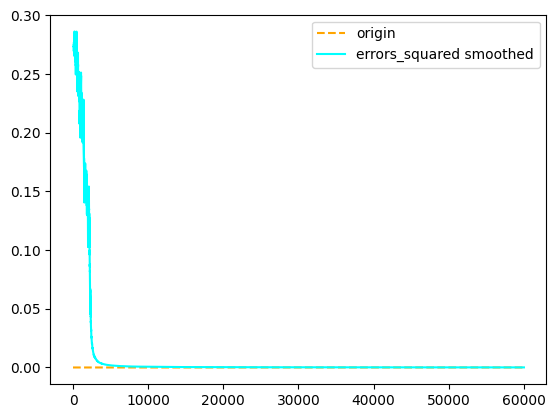

In [183]:
# Show smoothed loss function vs training steps
window_size = 100
errors_squared, smoothed_errors = XOR.get_smoothed_errors_squared(window_size)
errors_squared = errors_squared.flatten()
num_errors = len(errors_squared)
x_errors = np.linspace(0, num_errors, num_errors)
x_smoothed = np.linspace(window_size, num_errors, len(smoothed_errors))
origin = np.zeros(num_errors)
plt.plot(x_errors, origin, '--', label='origin', color='orange')
# plt.plot(x_errors, errors_squared, label="errors_squared raw", color='blue')
plt.plot(x_smoothed, smoothed_errors, label="errors_squared smoothed", color='cyan')
plt.legend()
plt.show()

In [113]:
nn = NeuralNetwork([2, 2, 2, 1], activation='sigmoid', verbose=False)

X = np.array([[0, 0],
            [0, 1],
            [0.5, 1],
            [0, 0.5],
            [1, 0],
            [1, 1]])
y = np.array([0, 0, 0, 1, 1, 1])

nn.fit(X, 
         y,
         steps=2*10**5,
         learning_rate=1.2,
         verbose=False)

Step: 0
Training Results(data, prediction, expected):
[0.0000 0.0000], 0.7718880350987595, 0
[0.0000 1.0000], 0.7735992396244773, 0
[0.5000 1.0000], 0.7766090654027695, 0
[0.0000 0.5000], 0.7727750900418506, 1
[1.0000 0.0000], 0.7777931497836112, 1
[1.0000 1.0000], 0.779215044218428, 1
RMS_err: 0.5696697293798113

Step: 20000
Training Results(data, prediction, expected):
[0.0000 0.0000], 0.7410023127135162, 0
[0.0000 1.0000], 0.05245265250074869, 0
[0.5000 1.0000], 0.036298100400263496, 0
[0.0000 0.5000], 0.740792306690468, 1
[1.0000 0.0000], 0.9996127138600228, 1
[1.0000 1.0000], 0.9958185887244164, 1
RMS_err: 0.32154821379161524

Step: 40000
Training Results(data, prediction, expected):
[0.0000 0.0000], 0.029999259765185804, 0
[0.0000 1.0000], 0.01929793926785371, 0
[0.5000 1.0000], 0.02357227021083419, 0
[0.0000 0.5000], 0.9682662015798937, 1
[1.0000 0.0000], 0.9930568476442785, 1
[1.0000 1.0000], 0.9841517048017284, 1
RMS_err: 0.022856172604760788

Step: 60000
Training Results(data

In [154]:
t = np.array([[[1]], [[1]], [[1]]])
print(t.shape)
print(np.ravel(t).shape)
print(t)
print(t.flatten().shape)
print(t.flatten())
print(np.ravel(t))

(3, 1, 1)
(3,)
[[[1]]

 [[1]]

 [[1]]]
(3,)
[1 1 1]
[1 1 1]
